# 版本说明v4 #
1. 使用LinearRegressor
2. 使用pipeline
3. 添加自定义的Transformer，可以选择指定的成分
4. 针对各个参数进行了调优
5. 封装了工具方法

# 拆分训练集和验证集 #

In [352]:
from hw1_utils import *
from sklearn.model_selection import train_test_split
%load_ext autoreload
%autoreload 2

X_train_full,y_train_full,X_test,test_option_index,test_options = load_data() # 加载训练和测试数据

X_train,X_valid,y_train,y_valid = train_test_split(X_train_full,
                                                   y_train_full,
                                                   test_size=0.2) # 分割验证集和验证集
n_features = X_train.shape[1]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 建立pipeline #

In [273]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

options = SelectTestOptionTransformer(test_option_index) # 选择测项特征的转化器

feature_model = Pipeline(steps=[('options',options),
                                ('scaler',StandardScaler())])
model = None
pipeline = Pipeline(steps=[('feature_model',feature_model),
                           ('model' , model)])

search_utils = SearchUtils(pipeline,X_train_full,y_train_full)

## 使用LinearRegression模型 ##

In [236]:
from sklearn.model_selection import cross_val_score

pipeline.steps[2] = ('model',LinearRegression())

cross_val_score(pipeline,X_train_full,y_train_full).mean()

0.8443606921920231

# 剔除无关Feature #
1. 将所有feature放进去，计算cv_score，记录为best score
2. 然后分别减掉一个feature，选出最高的cv_score，如果，如果比best_score，那么去掉这个feature
3. 然后重复上面的操作，直到最高的score不再比best_score高为止。

In [237]:
pipeline.steps[2] = ('model',LinearRegression())
options.exclude = []

train_best_scores = []
valid_best_scores = []
exclude_params = []
best_score = 0
flag = True
while flag:
    param_range = [exclude_params + [test_options[i]] for i in range(18)]
    
    train_scores,valid_scores = validation_curve(pipeline,X_train_full,y_train_full,
                                                 'options__exclude',param_range)
    
    valid_score = valid_scores.mean(axis=1)              # 取验证集每个feature的平均分
    valid_max = valid_score.max()                        # 取出最高分
    valid_argmax = valid_score.argmax()                  # 最高分对应的feature值
    train_max = train_scores.mean(axis=1)[valid_argmax]  # 该feature在训练集的分数作为训练集最高分
    
    if valid_max > best_score:
        train_best_scores.append(train_max)
        valid_best_scores.append(valid_max)
        best_score = valid_max
        if len(valid_score) > 1:
            test_option_killed = test_options[valid_argmax]
            exclude_params.append(test_option_killed)
        print('剔除{}后，训练集得分为{:.4f}，验证集得分为{:.4f}'.format(
            test_option_killed,train_max,valid_max))
            
    else:
        print('剔除完成。')
        flag = False

剔除RH后，训练集得分为0.8826，验证集得分为0.8459
剔除THC后，训练集得分为0.8824，验证集得分为0.8466
剔除NMHC后，训练集得分为0.8822，验证集得分为0.8472
剔除AMB_TEMP后，训练集得分为0.8818，验证集得分为0.8479
剔除WIND_DIREC后，训练集得分为0.8815，验证集得分为0.8483
剔除NO2后，训练集得分为0.8812，验证集得分为0.8487
剔除WS_HR后，训练集得分为0.8810，验证集得分为0.8489
剔除WIND_SPEED后，训练集得分为0.8807，验证集得分为0.8492
剔除WD_HR后，训练集得分为0.8804，验证集得分为0.8494
剔除RAINFALL后，训练集得分为0.8801，验证集得分为0.8495
剔除CH4后，训练集得分为0.8795，验证集得分为0.8495
剔除完成。


In [167]:
exclude_params 

['RH',
 'THC',
 'NMHC',
 'AMB_TEMP',
 'WIND_DIREC',
 'NO2',
 'WS_HR',
 'WIND_SPEED',
 'WD_HR',
 'RAINFALL',
 'CH4']

In [170]:
valid_best_scores

[0.8458928052416193,
 0.8465658857667734,
 0.8472180038136082,
 0.8478696241065699,
 0.8483088469965182,
 0.8486776551720734,
 0.8489273441770215,
 0.8491832160605401,
 0.849413436958576,
 0.8494950728665771,
 0.8495024139932805]

In [175]:
train_best_scores

[0.8825598602446174,
 0.8823771158273139,
 0.8821632742422434,
 0.8818185465025833,
 0.8815265470784478,
 0.8811858669055083,
 0.880950170396131,
 0.8806664794354901,
 0.8804019823989597,
 0.8800917772013973,
 0.8795468026598325]

In [176]:
best_score

0.8495024139932805

## 噪音过滤后的学习曲线 ##

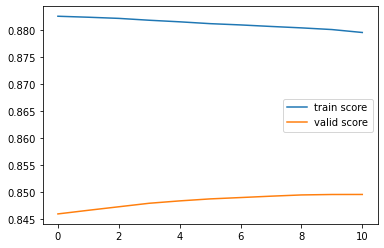

In [271]:
def plot_best_scores():
    x = len(train_best_scores)
    plt.plot(range(x),train_best_scores,label='train score')
    plt.plot(range(x),valid_best_scores,label='valid score')
    plt.legend()
    plt.show()
    
plot_best_scores()

# 方差过滤 #

## 保存之前获得的结果 ##

In [269]:
exclude_params = ['RH',
 'THC',
 'NMHC',
 'AMB_TEMP',
 'WIND_DIREC',
 'NO2',
 'WS_HR',
 'WIND_SPEED',
 'WD_HR',
 'RAINFALL',
 'CH4']

valid_best_scores = [0.8458928052416193,
 0.8465658857667734,
 0.8472180038136082,
 0.8478696241065699,
 0.8483088469965182,
 0.8486776551720734,
 0.8489273441770215,
 0.8491832160605401,
 0.849413436958576,
 0.8494950728665771,
 0.8495024139932805]

train_best_scores = [0.8825598602446174,
 0.8823771158273139,
 0.8821632742422434,
 0.8818185465025833,
 0.8815265470784478,
 0.8811858669055083,
 0.880950170396131,
 0.8806664794354901,
 0.8804019823989597,
 0.8800917772013973,
 0.8795468026598325]

best_score = 0.8495024139932805

## 配置pipeline ##

In [252]:
from sklearn.feature_selection import VarianceThreshold
if(len(pipeline.steps) == 3):
    pipeline.steps.insert(1,('variance',VarianceThreshold()))

options.exclude = exclude_params

pipeline.steps[3] = ('model',LinearRegression())
pipeline.steps

[('options',
  SelectTestOptionTransformer(exclude=['RH', 'THC', 'NMHC', 'AMB_TEMP',
                                       'WIND_DIREC', 'NO2', 'WS_HR', 'WIND_SPEED',
                                       'WD_HR', 'RAINFALL', 'CH4'],
                              exclude_index=None,
                              test_option_index={'AMB_TEMP': 0, 'CH4': 1, 'CO': 2,
                                                 'NMHC': 3, 'NO': 4, 'NO2': 5,
                                                 'NOx': 6, 'O3': 7, 'PM10': 8,
                                                 'PM2.5': 9, 'RAINFALL': 10,
                                                 'RH': 11, 'SO2': 12, 'THC': 13,
                                                 'WD_HR': 14, 'WIND_DIREC': 15,
                                                 'WIND_SPEED': 16, 'WS_HR': 17})),
 ('variance', VarianceThreshold(threshold=0.0)),
 ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
 ('model',
  LinearRegression(co

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    6.6s finished


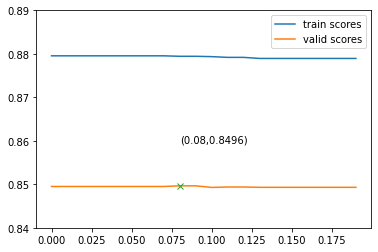

In [251]:
treshold_range = [0.01 * i for i in range(20)]

history = search_utils.search('variance__threshold',treshold_range,ylim=(.84,.89))

## 方差过滤后的学习曲线##

In [340]:
def plot_history(history,last_len):
    valid_scores = history[3].mean(axis=1)
    valid_max = valid_scores.max()
    valid_argmax = valid_scores.argmax()
    train_max = history[2][valid_argmax].mean()
    if len(valid_best_scores)==last_len:
        valid_best_scores.append(valid_max)
        train_best_scores.append(train_max)
    plot_best_scores()

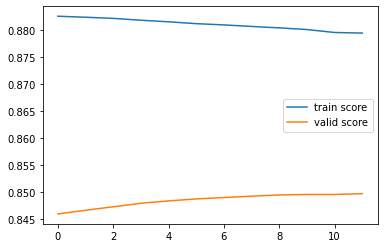

In [272]:
plot_history(history,11)

In [253]:
pipeline.steps[1][1].threshold = 0.08
pipeline.steps

[('options',
  SelectTestOptionTransformer(exclude=['RH', 'THC', 'NMHC', 'AMB_TEMP',
                                       'WIND_DIREC', 'NO2', 'WS_HR', 'WIND_SPEED',
                                       'WD_HR', 'RAINFALL', 'CH4'],
                              exclude_index=None,
                              test_option_index={'AMB_TEMP': 0, 'CH4': 1, 'CO': 2,
                                                 'NMHC': 3, 'NO': 4, 'NO2': 5,
                                                 'NOx': 6, 'O3': 7, 'PM10': 8,
                                                 'PM2.5': 9, 'RAINFALL': 10,
                                                 'RH': 11, 'SO2': 12, 'THC': 13,
                                                 'WD_HR': 14, 'WIND_DIREC': 15,
                                                 'WIND_SPEED': 16, 'WS_HR': 17})),
 ('variance', VarianceThreshold(threshold=0.08)),
 ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
 ('model',
  LinearRegression(c

# F值过滤 #

### 1. 初始feature_model

In [276]:
options.exclude = exclude_params

feature_model.steps.insert(1,('variance',VarianceThreshold(0.08)))
feature_model.steps

[('options',
  SelectTestOptionTransformer(exclude=['RH', 'THC', 'NMHC', 'AMB_TEMP',
                                       'WIND_DIREC', 'NO2', 'WS_HR', 'WIND_SPEED',
                                       'WD_HR', 'RAINFALL', 'CH4'],
                              exclude_index=None,
                              test_option_index={'AMB_TEMP': 0, 'CH4': 1, 'CO': 2,
                                                 'NMHC': 3, 'NO': 4, 'NO2': 5,
                                                 'NOx': 6, 'O3': 7, 'PM10': 8,
                                                 'PM2.5': 9, 'RAINFALL': 10,
                                                 'RH': 11, 'SO2': 12, 'THC': 13,
                                                 'WD_HR': 14, 'WIND_DIREC': 15,
                                                 'WIND_SPEED': 16, 'WS_HR': 17})),
 ('variance', VarianceThreshold(threshold=0.08)),
 ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True))]

### 2. 确定当前还有多少个Feature 

In [279]:
X_train_full.shape

(5652, 162)

In [278]:
X_data = feature_model.fit_transform(X_train_full)
X_data.shape

(5652, 63)

### 3. 通过p值确定k值 

In [282]:
from sklearn.feature_selection import f_regression
X_data_f,X_data_p = f_regression(X_data,y_train_full) 
X_data_p

array([9.01953121e-040, 1.18122809e-050, 1.83153002e-064, 7.82431674e-077,
       3.23492200e-092, 1.15861494e-105, 5.09042927e-124, 2.29597452e-137,
       7.02550385e-130, 2.35349439e-026, 7.64788415e-030, 2.04611728e-033,
       2.74239657e-033, 1.10780484e-033, 6.97806615e-032, 3.64720657e-028,
       4.65089293e-020, 2.45734722e-009, 6.83391962e-075, 2.51764284e-094,
       6.57990780e-119, 3.81322547e-144, 3.57100502e-172, 3.48356375e-199,
       4.94767136e-226, 4.87070124e-244, 6.62053998e-230, 2.39271738e-026,
       3.86177177e-040, 7.06270621e-058, 9.38726691e-081, 1.24949041e-108,
       2.44901093e-139, 1.62974941e-168, 1.27772567e-188, 1.02066189e-190,
       2.60193240e-211, 1.55752152e-257, 3.93030026e-308, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 6.83245693e-258, 2.98072184e-307, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0

In [286]:
(X_data_p < 0.05).sum()

63

### 4. 添加到pipeline中

In [304]:
from sklearn.feature_selection import SelectKBest
if len(feature_model.steps) == 3:
    feature_model.steps.append(('f',SelectKBest(f_regression,63)))
pipeline.steps[1] = ('model',LinearRegression())
pipeline.steps

[('feature_model',
  Pipeline(memory=None,
           steps=[('options',
                   SelectTestOptionTransformer(exclude=['RH', 'THC', 'NMHC',
                                                        'AMB_TEMP', 'WIND_DIREC',
                                                        'NO2', 'WS_HR',
                                                        'WIND_SPEED', 'WD_HR',
                                                        'RAINFALL', 'CH4'],
                                               exclude_index=None,
                                               test_option_index={'AMB_TEMP': 0,
                                                                  'CH4': 1,
                                                                  'CO': 2,
                                                                  'NMHC': 3,
                                                                  'NO': 4,
                                                                  'NO2': 5,
              

### 5. 画学习曲线 
1. 从p值分析来看，所有的Feature都是相关的
2. 但是，画学习曲线发现，当k取值是54时，准确率显著提升，但是，最后test的测试数据有下降
3. 把cv提升到10之后，发现原来54时的悬崖消失了，但是高点在36，不过整体差别不大  

**总结**:以p值分析为准，学习曲线和test效果不一致有可能是测试随机性导致的

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 315 out of 315 | elapsed:   20.6s finished


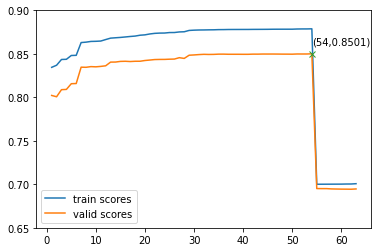

In [353]:
history = search_utils.search('feature_model__f__k',range(1,64),ylim=(0.65,0.9))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 630 out of 630 | elapsed:   42.2s finished


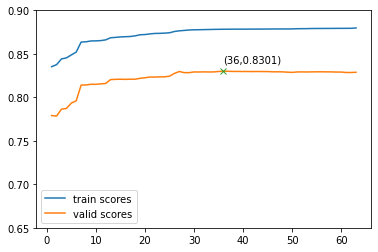

In [354]:
history = search_utils.search('feature_model__f__k',range(1,64),ylim=(0.65,0.9),cv=10)

### 6. 画学习曲线 

In [338]:
len(train_best_scores)

12

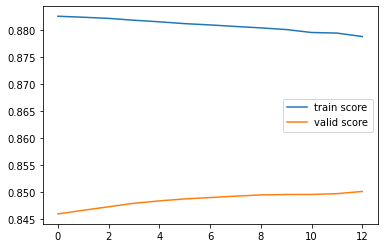

In [341]:
plot_history(history,12)

# 互信息法

## 测试一下数据

In [367]:
feature_model.steps.remove(feature_model.steps[3])
feature_model.steps

[('options',
  SelectTestOptionTransformer(exclude=['RH', 'THC', 'NMHC', 'AMB_TEMP',
                                       'WIND_DIREC', 'NO2', 'WS_HR', 'WIND_SPEED',
                                       'WD_HR', 'RAINFALL', 'CH4'],
                              exclude_index=None,
                              test_option_index={'AMB_TEMP': 0, 'CH4': 1, 'CO': 2,
                                                 'NMHC': 3, 'NO': 4, 'NO2': 5,
                                                 'NOx': 6, 'O3': 7, 'PM10': 8,
                                                 'PM2.5': 9, 'RAINFALL': 10,
                                                 'RH': 11, 'SO2': 12, 'THC': 13,
                                                 'WD_HR': 14, 'WIND_DIREC': 15,
                                                 'WIND_SPEED': 16, 'WS_HR': 17})),
 ('variance', VarianceThreshold(threshold=0.08)),
 ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True))]

In [368]:
X_data = feature_model.fit_transform(X_train_full,y_train_full)
X_data.shape

(5652, 63)

In [370]:
from sklearn.feature_selection import mutual_info_regression

X_data1 = mutual_info_regression(X_train_full,y_train_full)
X_data1

array([0.06762967, 0.07488442, 0.06595027, 0.09132981, 0.05775086,
       0.07793993, 0.06691501, 0.08589263, 0.08437736, 0.04481928,
       0.05520053, 0.07349067, 0.05793533, 0.07629211, 0.07686025,
       0.09103272, 0.07334595, 0.08891713, 0.06995463, 0.1139323 ,
       0.12262258, 0.12227581, 0.13881322, 0.16999182, 0.17508876,
       0.17836935, 0.18260254, 0.03273758, 0.04729347, 0.05712293,
       0.04643427, 0.08631747, 0.08100352, 0.09119633, 0.09677759,
       0.11567184, 0.00534948, 0.02904804, 0.01853443, 0.02014136,
       0.03971885, 0.03044068, 0.01475069, 0.01614043, 0.03592388,
       0.0468296 , 0.06091999, 0.07142459, 0.06306555, 0.08599154,
       0.11324399, 0.13451738, 0.14937575, 0.15938898, 0.03696703,
       0.04962441, 0.06271606, 0.06497788, 0.07208802, 0.09311822,
       0.10756142, 0.11399585, 0.09691902, 0.03537626, 0.04253387,
       0.06336896, 0.0629532 , 0.08025341, 0.08576251, 0.12291564,
       0.11882384, 0.12592994, 0.0892836 , 0.129517  , 0.14066

In [374]:
X_data.shape[1] - (X_data1 == 0).sum()

61

## 使用互信息法 ##

In [391]:
if len(feature_model.steps) == 3:
    feature_model.steps.append(('mir',SelectKBest(mutual_info_regression,61)))
pipeline.steps[1] = ('model',LinearRegression())
pipeline.steps

[('feature_model',
  Pipeline(memory=None,
           steps=[('options',
                   SelectTestOptionTransformer(exclude=['RH', 'THC', 'NMHC',
                                                        'AMB_TEMP', 'WIND_DIREC',
                                                        'NO2', 'WS_HR',
                                                        'WIND_SPEED', 'WD_HR',
                                                        'RAINFALL', 'CH4'],
                                               exclude_index=None,
                                               test_option_index={'AMB_TEMP': 0,
                                                                  'CH4': 1,
                                                                  'CO': 2,
                                                                  'NMHC': 3,
                                                                  'NO': 4,
                                                                  'NO2': 5,
              

In [392]:
X_data2 = feature_model.fit_transform(X_train_full,y_train_full) # 测试feature_model是否可以正常

In [393]:
X_data2.shape # 测试返回结果是否删除0关联feature

(5652, 61)

In [395]:
pipeline.fit(X_train_full,y_train_full)

Pipeline(memory=None,
         steps=[('feature_model',
                 Pipeline(memory=None,
                          steps=[('options',
                                  SelectTestOptionTransformer(exclude=['RH',
                                                                       'THC',
                                                                       'NMHC',
                                                                       'AMB_TEMP',
                                                                       'WIND_DIREC',
                                                                       'NO2',
                                                                       'WS_HR',
                                                                       'WIND_SPEED',
                                                                       'WD_HR',
                                                                       'RAINFALL',
                                                    

In [396]:
pipeline.score(X_train_full,y_train_full)

0.8800980196540122

In [383]:
cross_val_score(pipeline,X_train_full,y_train_full).mean()

/Users/zhangshilan/.pyenv/versions/new/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: k should be >=0, <= n_features = 54; got 61. Use k='all' to return all features.

  FitFailedWarning)


nan

# 输出数据 #

In [397]:
pipeline.steps

[('feature_model',
  Pipeline(memory=None,
           steps=[('options',
                   SelectTestOptionTransformer(exclude=['RH', 'THC', 'NMHC',
                                                        'AMB_TEMP', 'WIND_DIREC',
                                                        'NO2', 'WS_HR',
                                                        'WIND_SPEED', 'WD_HR',
                                                        'RAINFALL', 'CH4'],
                                               exclude_index=None,
                                               test_option_index={'AMB_TEMP': 0,
                                                                  'CH4': 1,
                                                                  'CO': 2,
                                                                  'NMHC': 3,
                                                                  'NO': 4,
                                                                  'NO2': 5,
              

In [398]:
pipeline.fit(X_train_full,y_train_full)

preds_train_full = pipeline.predict(X_train_full)
print('训练集的RMSE:{:.5f}'.format(mean_squared_error(preds_train_full,y_train_full)**0.5))

preds_test = pipeline.predict(X_test)
ids = ['id_' + str(i) for i in range(len(X_test))]
output = pd.DataFrame({'id':ids,
                       'value':preds_test})
output.to_csv('output/pm25_submission.csv',index=False)

训练集的RMSE:5.75124


# 使用随机森林 #

In [358]:
pipeline.steps[1] = ('model',RandomForestRegressor())
pipeline.steps

[('feature_model',
  Pipeline(memory=None,
           steps=[('options',
                   SelectTestOptionTransformer(exclude=['RH', 'THC', 'NMHC',
                                                        'AMB_TEMP', 'WIND_DIREC',
                                                        'NO2', 'WS_HR',
                                                        'WIND_SPEED', 'WD_HR',
                                                        'RAINFALL', 'CH4'],
                                               exclude_index=None,
                                               test_option_index={'AMB_TEMP': 0,
                                                                  'CH4': 1,
                                                                  'CO': 2,
                                                                  'NMHC': 3,
                                                                  'NO': 4,
                                                                  'NO2': 5,
              

In [359]:
cross_val_score(pipeline,X_train_full,y_train_full).mean()

0.8094118087976636